#Data loading & Seed setting

In [1]:
import numpy as np
import tensorflow as tf
import random
import os

# Set random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
!pip install tensorflow
!pip install Tokenizer
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 5.4 MB/s eta 0:00:00


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Feature Engineering
##Tokenization

In [4]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D

# Load spacy English model
import spacy
nlp = spacy.load("en_core_web_sm")

# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove extra spaces
    text = text.strip()
    return text

# Spacy tokenization and lemmatization function
def spacy_tokenize_and_lemmatize(text):
    doc = nlp(text)  # Process text with spacy
    # Tokenize and lemmatize, filtering out stopwords
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

# Clean the text
train["clean_text"] = train["text"].apply(clean_text)

In [5]:
# Apply Spacy tokenization and lemmatization
train["processed_text"] = train["clean_text"].apply(spacy_tokenize_and_lemmatize)

# Show processed text
print(train["processed_text"].head())

0                 deed reason earthquake allah forgive
1                forest fire near la ronge sask canada
2    resident ask shelter place notify officer evac...
3    people receive wildfire evacuation order calif...
4    get send photo ruby alaska smoke wildfires pou...
Name: processed_text, dtype: object


Longest sequence: 20
Average sequence length: 7.24615788782346
Median sequence length: 7.0


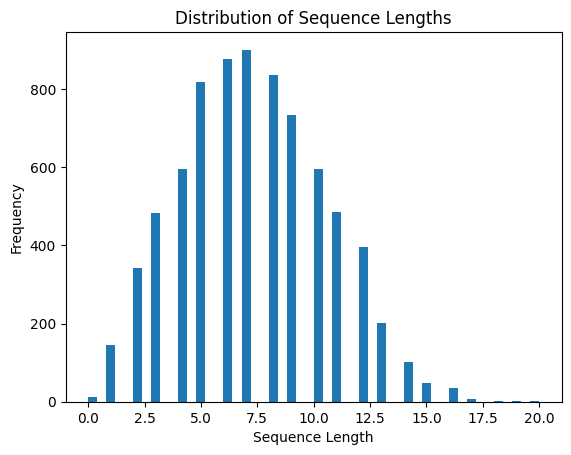

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)  # Limit to top 5000 words
tokenizer.fit_on_texts(train["processed_text"])

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(train["processed_text"])

# Calculate the actual length of each sequence
actual_lengths = [len(seq) for seq in X_train]
print("Longest sequence:", max(actual_lengths))
print("Average sequence length:", np.mean(actual_lengths))
print("Median sequence length:", np.median(actual_lengths))

# Calculate the length of each sample
sequence_lengths = [len(seq) for seq in X_train]
plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()


In [7]:
# Compute histogram data
counts, bin_edges = np.histogram(sequence_lengths, bins=50)

# Create a DataFrame for better readability
hist_df = pd.DataFrame({
    "Bin Start": bin_edges[:-1],  # Lower bound of each bin
    "Bin End": bin_edges[1:],     # Upper bound of each bin
    "Count": counts               # Number of values in the bin
})

# Print the histogram data
print(hist_df)

# Save to CSV
hist_df.to_csv("sequence_length_distribution.csv", index=False)
print("Histogram data saved as sequence_length_distribution.csv")


    Bin Start  Bin End  Count
0         0.0      0.4     13
1         0.4      0.8      0
2         0.8      1.2    146
3         1.2      1.6      0
4         1.6      2.0      0
5         2.0      2.4    341
6         2.4      2.8      0
7         2.8      3.2    483
8         3.2      3.6      0
9         3.6      4.0      0
10        4.0      4.4    594
11        4.4      4.8      0
12        4.8      5.2    817
13        5.2      5.6      0
14        5.6      6.0      0
15        6.0      6.4    877
16        6.4      6.8      0
17        6.8      7.2    900
18        7.2      7.6      0
19        7.6      8.0      0
20        8.0      8.4    835
21        8.4      8.8      0
22        8.8      9.2    732
23        9.2      9.6      0
24        9.6     10.0      0
25       10.0     10.4    594
26       10.4     10.8      0
27       10.8     11.2    486
28       11.2     11.6      0
29       11.6     12.0      0
30       12.0     12.4    395
31       12.4     12.8      0
32       1

In [8]:
# Pad sequences to make them the same length
X_train = pad_sequences(X_train, padding='post', maxlen=25)  # Limit sequence length to 25

# Show padded sequences
print(X_train.shape)


(7613, 25)


##Test set structure processing

In [9]:
# Clean test data
test["clean_text"] = test["text"].apply(clean_text)

# Apply Spacy tokenization and lemmatization
test["processed_text"] = test["clean_text"].apply(spacy_tokenize_and_lemmatize)

# Convert text to sequences for test set (using the Tokenizer from the training set)
X_test = tokenizer.texts_to_sequences(test["processed_text"])

# Pad sequences to make them the same length as the training data
X_test = pad_sequences(X_test, padding='post', maxlen=25)

##One-hot encoding of the 'keyword'

In [10]:
# One-hot encoding of the 'keyword' column
X_train_keyword = pd.get_dummies(train['keyword'], prefix='keyword', drop_first=True)
X_test_keyword = pd.get_dummies(test['keyword'], prefix='keyword', drop_first=True)

In [11]:
# Ensure the columns of the training and test sets are consistent
X_train_keyword, X_test_keyword = X_train_keyword.align(X_test_keyword, join='left', axis=1)

# Fill NaN values with 0
X_test_keyword.fillna(0, inplace=True)

# Check shapes
print(X_train_keyword.shape)
print(X_test_keyword.shape)

(7613, 220)
(3263, 220)


##Data Cleaning and One-Hot Encoding of 'Location'

In [12]:
import re
import pandas as pd

# Clean the noise and special characters from the location column
def clean_location(location):
    # If location is NaN or not a string, return an empty string
    if isinstance(location, float) and pd.isna(location):
        return ''
    if not isinstance(location, str):  # If it's not a string, return empty
        return ''

    # Remove special characters using regular expressions, keeping only letters and spaces
    location = re.sub(r'[^a-zA-Z\s]', '', location)

    # Remove leading and trailing spaces
    location = location.strip()
    return location

# Clean the location column in the training set
train['clean_location'] = train['location'].apply(clean_location)

# Clean the location column in the test set
test['clean_location'] = test['location'].apply(clean_location)

# Fill NaN values in the test set with an empty string
test['clean_location'].fillna('', inplace=True)

# Perform One-Hot Encoding
X_train_location = pd.get_dummies(train['clean_location'])
X_test_location = pd.get_dummies(test['clean_location'])

# Ensure that the columns in the training and test sets are consistent, this will automatically align them
X_train_location, X_test_location = X_train_location.align(X_test_location, join='left', axis=1)

# Fill NaN values with 0, because the test set may contain categories not present in the training set
X_test_location.fillna(0, inplace=True)

# Check if the shapes are consistent
print(X_train_location.shape)
print(X_test_location.shape)

<ipython-input-12-0107b2cd46b3>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['clean_location'].fillna('', inplace=True)


(7613, 3102)
(3263, 3102)


In [13]:
import numpy as np

# Ensure that the values of X_train_location and X_test_location are converted to numpy arrays, and then check for NaN values.
print(np.isnan(X_train_location.values.astype(float)).sum())
print(np.isnan(X_test_location.values.astype(float)).sum())

0
0


##Additional Features - Sentiment Score

In [14]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [15]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# "processed_text" is the text column I want to perform sentiment analysis on
# Initialize the sentiment analysis tool
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment score
def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)  # Calculate sentiment scores
    return sentiment['compound']  # Return the compound sentiment score

# Assuming your training data is in train and "processed_text" has already been cleaned and processed
train['sentiment_score'] = train['processed_text'].apply(get_sentiment_score)

# Display the results
print(train[['processed_text', 'sentiment_score']].head())

                                      processed_text  sentiment_score
0               deed reason earthquake allah forgive           0.2732
1              forest fire near la ronge sask canada          -0.3400
2  resident ask shelter place notify officer evac...           0.0000
3  people receive wildfire evacuation order calif...           0.0000
4  get send photo ruby alaska smoke wildfires pou...           0.0000


In [16]:
# Assuming sentiment_score is a numerical feature
X_train_sentiment_score = train['sentiment_score'].values

# Ensure it's a column vector (so it can be concatenated with other feature matrices)
X_train_sentiment_score = X_train_sentiment_score.reshape(-1, 1)

In [17]:
# Perform the same processing on the test data
test['sentiment_score'] = test['processed_text'].apply(get_sentiment_score)

# Display the results
print(test[['processed_text', 'sentiment_score']].head())

# Assuming sentiment_score is a numerical feature
X_test_sentiment_score = test['sentiment_score'].values

# Ensure it's a column vector (so it can be concatenated with other feature matrices)
X_test_sentiment_score = X_test_sentiment_score.reshape(-1, 1)

                                 processed_text  sentiment_score
0                     happen terrible car crash          -0.7003
1      hear earthquake different city stay safe           0.4404
2  forest fire spot pond geese flee street save           0.2023
3             apocalypse light spokane wildfire           0.0000
4          typhoon soudelor kill   china taiwan          -0.6908


#Model building

In [18]:
# View all column names in the train dataset
print(train.columns)
print(train.head())

# View all column names in the test dataset
print(test.columns)
print(test.head())

Index(['id', 'keyword', 'location', 'text', 'target', 'clean_text',
       'processed_text', 'clean_location', 'sentiment_score'],
      dtype='object')
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         clean_text  \
0       1  our deeds are the reason of this earthquake ma...   
1       1              forest fire near la ronge sask canada   
2       1  all residents asked to shelter in place are be...   
3       1  people receive wildfires evacuation orders in ...   
4       1  just got sent this photo from ruby alaska as s...   


In [19]:
# Exclude unnecessary columns
train = train.drop(columns=['id', 'keyword','location', 'text', 'clean_text', 'clean_location'])

In [20]:
# Print the shape
print(X_train.shape)
print(X_train_location.shape)
print(X_train_keyword.shape)
print(X_train_sentiment_score.shape)

(7613, 25)
(7613, 3102)
(7613, 220)
(7613, 1)


In [21]:
# Display the data for the first text in the training set
print(X_train[0])

# Display the word count of the first text
print(len(X_train[0]))


[3614  405  177 1251 1938    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
25


In [22]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, BatchNormalization, Concatenate, Activation, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D


# Define the F1 score metric
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round the predicted values
    tp = K.sum(K.cast(y_true, 'float32') * y_pred)  # True Positives
    fp = K.sum(K.cast((1 - y_true), 'float32') * y_pred)  # False Positives
    fn = K.sum(K.cast(y_true, 'float32') * (1 - y_pred))  # False Negatives

    precision = tp / (tp + fp + K.epsilon())  # Add K.epsilon() to avoid division by 0
    recall = tp / (tp + fn + K.epsilon())  # Add K.epsilon() to avoid division by 0

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # Calculate F1 score
    return f1



# Clear old session to ensure no previous computational graph interferes
K.clear_session()

# Define the text input
input_text = Input(shape=(25,), name='input_text')

# Embedding layer
embedding = Embedding(input_dim=5000, output_dim=128, input_length=25)(input_text)

# Conv1D layer + MaxPooling1D layer
conv1d = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)
maxpooling = MaxPooling1D(pool_size=2)(conv1d)

# LSTM layer + L2 regularization
lstm = LSTM(64, kernel_regularizer=l2(0.001))(maxpooling)
lstm = Dropout(0.6)(lstm)

# Define additional inputs
input_location = Input(shape=(3102,), name='input_location')
input_sentiment = Input(shape=(1,), name='input_sentiment')
input_keyword = Input(shape=(220,), name='input_keyword')

# Concatenate all inputs
concatenated = Concatenate()([lstm, input_location, input_sentiment, input_keyword])

# Dense layer + Swish + BatchNormalization + L2 regularization
dense = Dense(128, kernel_regularizer=l2(0.001))(concatenated)
dense = Activation('swish')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.4)(dense)

# Output layer
output = Dense(1, activation='sigmoid')(dense)

# Define the model
model = Model(inputs=[input_text, input_location, input_sentiment, input_keyword], outputs=output)

# Compile the model with F1 score metric
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Define the target variable y_train from the train dataset
y_train = train['target']

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Other input features are split as well
X_train_location, X_val_location = train_test_split(X_train_location, test_size=0.2, random_state=42)
X_train_sentiment_score, X_val_sentiment_score = train_test_split(X_train_sentiment_score, test_size=0.2, random_state=42)
X_train_keyword, X_val_keyword = train_test_split(X_train_keyword, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
# Print the shape
print(X_train.shape)
print(X_train_location.shape)
print(X_train_sentiment_score.shape)
print(X_train_keyword.shape)

print(X_test.shape)
print(X_test_location.shape)
print(X_test_sentiment_score.shape)
print(X_test_keyword.shape)

(6090, 25)
(6090, 3102)
(6090, 1)
(6090, 220)
(3263, 25)
(3263, 3102)
(3263, 1)
(3263, 220)


##Model training

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


# Set up the ModelCheckpoint callback function
checkpoint = ModelCheckpoint(
  'best_model.keras',
  monitor='val_loss',
  save_best_only=True
)


# Set up the EarlyStopping callback
early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True
)


# Set up the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=3,
  min_lr=0.00001
)

# Train the model
history = model.fit(
  [X_train, X_train_location, X_train_sentiment_score, X_train_keyword], y_train,
  validation_data=([X_val, X_val_location, X_val_sentiment_score, X_val_keyword], y_val),
  epochs=50,
  batch_size=32,
  callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.5718 - f1_score: 0.5366 - loss: 0.9997 - val_accuracy: 0.6225 - val_f1_score: 0.2356 - val_loss: 0.8682 - learning_rate: 1.0000e-04
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.7057 - f1_score: 0.6568 - loss: 0.7554 - val_accuracy: 0.7695 - val_f1_score: 0.6913 - val_loss: 0.7498 - learning_rate: 1.0000e-04
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8067 - f1_score: 0.7632 - loss: 0.5692 - val_accuracy: 0.7905 - val_f1_score: 0.7372 - val_loss: 0.6014 - learning_rate: 1.0000e-04
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8800 - f1_score: 0.8528 - loss: 0.4262 - val_accuracy: 0.7728 - val_f1_score: 0.7310 - val_loss: 0.6734 - learning_rate: 1.0000e-04
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9266 - f1_score: 0.9107 - loss: 0.3075 - val_accuracy: 0.7229 - val_f1_score: 0.7122 - val_loss: 0.9151 - learning_rate: 1.0000e-04
Ep

###Visualizing the model architecture

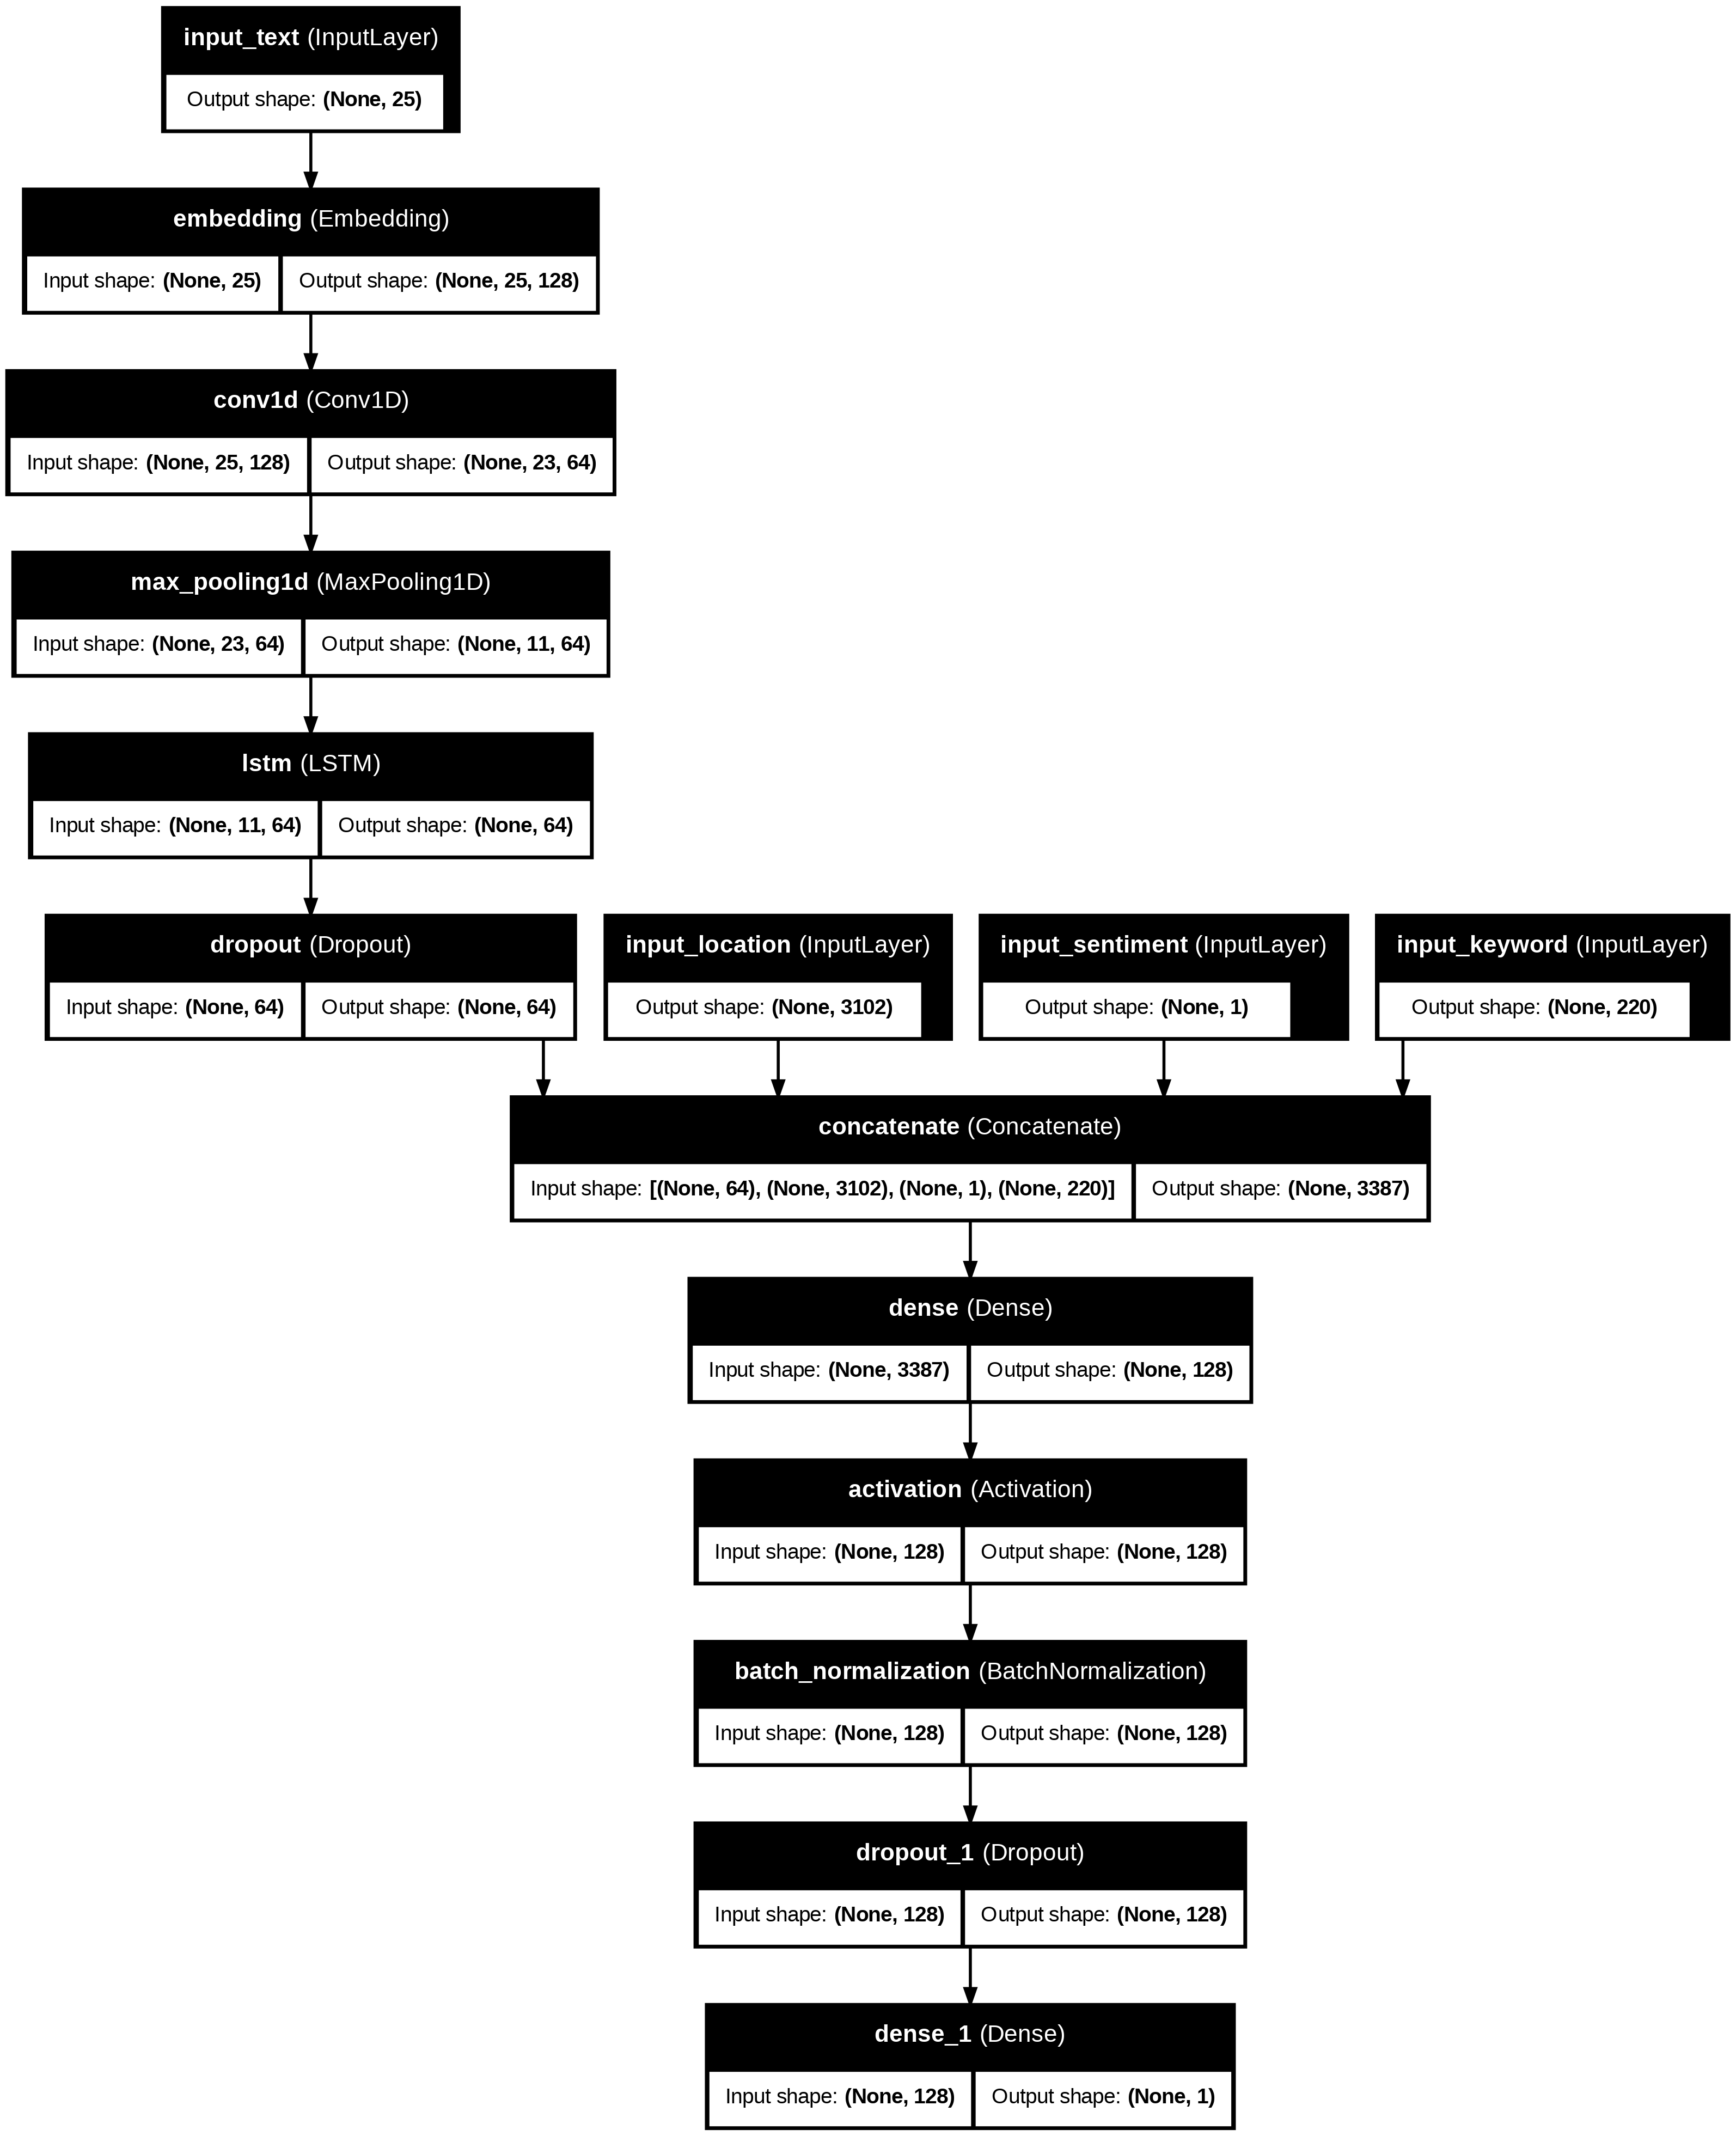

In [25]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# If you want to display the plot directly in a Jupyter notebook:
from IPython.display import Image
Image(filename='model_architecture.png')

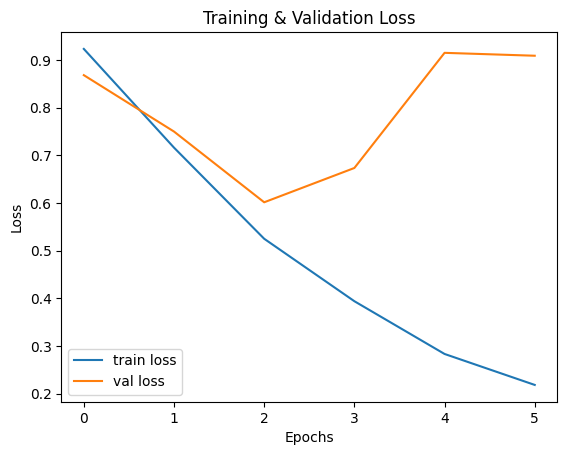

In [26]:
# Plot the loss during training
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

#Model Prediction

In [27]:
import numpy as np
from sklearn.metrics import f1_score

# Find the Best Threshold
best_thresh = 0.5
best_f1 = 0

for t in np.arange(0.1, 0.9, 0.05):
    val_pred = (model.predict([X_val, X_val_location, X_val_sentiment_score, X_val_keyword]) > t).astype(int)
    f1 = f1_score(y_val, val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best Threshold: {best_thresh}, Best F1: {best_f1}")

# Classify the Test Set Using the Best Threshold
predictions = model.predict([X_test, X_test_location, X_test_sentiment_score, X_test_keyword])
predictions = (predictions > best_thresh).astype(int) # Use the best threshold

# Generate Kaggle Submission File
submission = pd.DataFrame({
    'id': test['id'],
    'target': predictions.flatten()  # Flatten the results for submission
})

# Display the first few rows of the submission file
print(submission.head())

# Save the result as a CSV file
submission.to_csv('submission_v9-dropout5.csv', index=False)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best Threshold: 0.5000000000000001, Best F1: 0.7417004048582996
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


##Visualizing Validation Set Predictions

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
<class 'numpy.ndarray'>
(1523, 1)
y_val_pred is correctly formatted


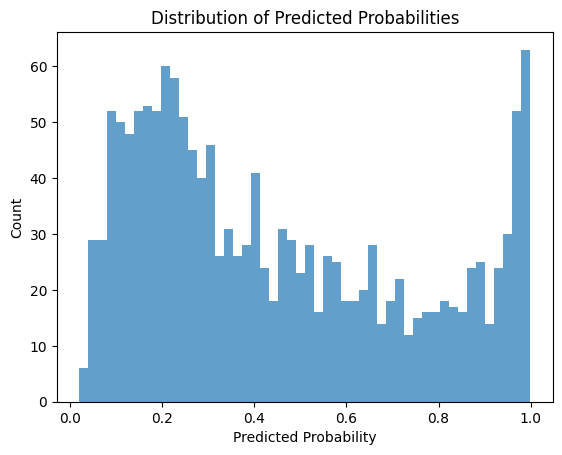

In [28]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred = model.predict([X_val, X_val_location, X_val_sentiment_score, X_val_keyword])
print(type(y_val_pred))  # Check the type
print(y_val_pred.shape)  # Check the dimensions

# Convert to a 1D NumPy array
y_val_pred = np.array(y_val_pred).flatten()

# Check if y_val_pred is a DataFrame and flatten it to a 1D array if it is
if isinstance(y_val_pred, pd.DataFrame):
    y_val_pred = y_val_pred.values.flatten()

# Ensure y_val_pred is not None and contains data before proceeding
if y_val_pred is not None and len(y_val_pred) > 0:
    print("y_val_pred is correctly formatted")

# Plot the distribution of predicted probabilities for the validation set
plt.hist(y_val_pred, bins=50, alpha=0.7)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities")
plt.show()

In [29]:
import numpy as np

# Compute histogram data
counts, bin_edges = np.histogram(y_val_pred, bins=50)

# Create a DataFrame for better readability
hist_df = pd.DataFrame({
    "Bin Start": bin_edges[:-1],  # Lower bound of each bin
    "Bin End": bin_edges[1:],     # Upper bound of each bin
    "Count": counts               # Number of values in the bin
})

# Print the histogram data
print(hist_df)

# Save as csv file
hist_df.to_csv("histogram_data.csv", index=False)
print("Histogram data saved as histogram_data.csv")

    Bin Start   Bin End  Count
0    0.020834  0.040401      6
1    0.040401  0.059968     29
2    0.059968  0.079535     29
3    0.079535  0.099102     52
4    0.099102  0.118670     50
5    0.118670  0.138237     48
6    0.138237  0.157804     52
7    0.157804  0.177371     53
8    0.177371  0.196938     52
9    0.196938  0.216505     60
10   0.216505  0.236072     58
11   0.236072  0.255639     51
12   0.255639  0.275207     45
13   0.275207  0.294774     40
14   0.294774  0.314341     46
15   0.314341  0.333908     26
16   0.333908  0.353475     31
17   0.353475  0.373042     26
18   0.373042  0.392609     28
19   0.392609  0.412176     41
20   0.412176  0.431744     24
21   0.431744  0.451311     18
22   0.451311  0.470878     31
23   0.470878  0.490445     29
24   0.490445  0.510012     23
25   0.510012  0.529579     28
26   0.529579  0.549146     16
27   0.549146  0.568713     26
28   0.568713  0.588281     25
29   0.588281  0.607848     18
30   0.607848  0.627415     18
31   0.6

In [30]:
#Check the distribution of predicted results (0 and 1).
print("Prediction Results Distribution：", np.unique(predictions, return_counts=True))

Prediction Results Distribution： (array([0, 1]), array([2077, 1186]))


In [31]:
#Check the Distribution of 0 and 1 in y_val
print("Class Balance of Training Set：", np.unique(y_val, return_counts=True))

Class Balance of Training Set： (array([0, 1]), array([874, 649]))
